## Dataset Information

The training archive contains 25,000 images of dogs and cats. Train your algorithm on these files and predict the labels

(1 = dog, 0 = cat).

# **1.   Descargar el Dataset asociado.**

In [ ]:
!wget   https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

# **2.   Descomprimir el Dataset.**

In [ ]:
 !unzip kagglecatsanddogs_5340.zip

# **3.   Importar Modulos.**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import tqdm
import random
from tensorflow.keras.utils import load_img
warnings.filterwarnings('ignore')

# **4. Crear la estructura de datos para las entradas y salidas.**

In [ ]:
input_path = []
label = []

for class_name in os.listdir("PetImages"):
    for path in os.listdir("PetImages/"+class_name):
        if class_name == 'Cat':
            label.append(0)
        else:
            label.append(1)
        input_path.append(os.path.join("PetImages", class_name, path))
print(input_path[0], label[0])

PetImages/Cat/12259.jpg 0


In [ ]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

In [ ]:
for i in df['images']:
    if '.jpg' not in i:
        print(i)

In [ ]:
import PIL
l = []
for image in df['images']:
    try:
        img = PIL.Image.open(image)
    except:
        l.append(image)
l

In [ ]:
# delete db files
df = df[df['images']!='PetImages/Dog/Thumbs.db']
df = df[df['images']!='PetImages/Cat/Thumbs.db']
df = df[df['images']!='PetImages/Cat/666.jpg']
df = df[df['images']!='PetImages/Dog/11702.jpg']
len(df)

# **5.   Análisis exploratorio de datos.**

In [ ]:
# to display grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==1]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Perro')
    plt.axis('off')

In [ ]:
# to display grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==0]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Gato')
    plt.axis('off')

<Figure size 2500x2500 with 0 Axes>

In [ ]:
import seaborn as sns
sns.countplot(df['label'])

# **6.   Crear un generador de datos para las imágenes.**

In [ ]:
df['label'] = df['label'].astype('str')

In [ ]:
df.head()

,images,label
0,PetImages/Cat/5598.jpg,0
1,PetImages/Cat/10887.jpg,0
2,PetImages/Dog/12308.jpg,1
3,PetImages/Dog/3833.jpg,1
4,PetImages/Dog/8707.jpg,1


In [ ]:
# input split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255,  # normalization of images
    rotation_range = 40, # augmention of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow_from_dataframe(
    train,
    x_col='images',
    y_col='label',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)

val_iterator = val_generator.flow_from_dataframe(
    test,
    x_col='images',
    y_col='label',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


## 7. Crear el Modelo.

In [ ]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
                    #Conv2D( 8, (3,3), activation='relu', input_shape=(128,128,3)),
                    Dropout(0.15),
                    MaxPool2D((2,2)),

                    Conv2D(32, (3,3), activation='relu'),
                    #Conv2D(16, (3,3), activation='relu'),
                    Dropout(0.15),
                    MaxPool2D((2,2)),

                    Conv2D(64, (3,3), activation='relu'),
                    #Conv2D(24, (3,3), activation='relu'),
                    Dropout(0.15),
                    MaxPool2D((2,2)),

                    Conv2D(128, (3,3), activation='relu'),
                    #Conv2D(24, (3,3), activation='relu'),
                    Dropout(0.15),                                              # Eliminación de enlaces entre nodos
                    MaxPool2D((2,2)),                                           # Agrupamiento de enlaces

                    Flatten(),                                                  # Aplanamiento de las capas de entrada.
                    #Dense(512, activation='relu'),
                    Dense(48, activation='relu'),
                    Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(train_iterator, epochs=1, validation_data=val_iterator)
while( history.history['accuracy'][0] < .75 ):
  history = model.fit(train_iterator, epochs=1, validation_data=val_iterator)

40/40 [==============================] - 117s 3s/step - loss: 0.4968 - accuracy: 0.7595 - val_loss: 0.5216 - val_accuracy: 0.7394


## 8. Visualizar los resultados.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

## 9. Probar con cualquier imagen.

1/1 [==============================] - 0s 19ms/step
Perro


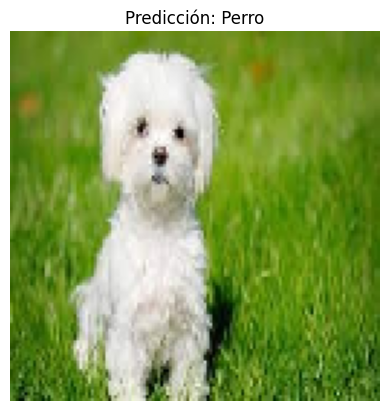

In [ ]:
image_path = "Perro_1.jpg" # path of the image
#image_path = "Gorila.jfif" # path of the image
img = load_img(image_path, target_size=(128, 128))
img = np.array(img)
img = img / 255.0 # normalize the image
img_array = img
img = img.reshape(1, 128, 128, 3) # reshape for prediction
pred = model.predict(img)

if pred[0] > 0.5:
    label = 'Perro'
else:
    label = 'Gato'
print(label)

# Mostrar la imagen
plt.imshow(img_array)
plt.title('Predicción: ' + label)
plt.axis('off')
plt.show()

Dataset Information
The training archive contains 25,000 images of dogs and cats. Train your algorithm on these files and predict the labels

(1 = dog, 0 = cat).

In [ ]:
#------------------------------------------------------------------------
#   1. Descargar el Dataset asociado.
#------------------------------------------------------------------------
!wget   https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

#------------------------------------------------------------------------
#   2. Descomprimir el Dataset.
#------------------------------------------------------------------------
!unzip kagglecatsanddogs_5340.zip

#------------------------------------------------------------------------
#   3. Importar Modulos.
#------------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import tqdm
import random
from tensorflow.keras.utils import load_img
warnings.filterwarnings('ignore')

#------------------------------------------------------------------------
#   4. Crear la estructura de datos para las entradas y salidas.
#------------------------------------------------------------------------
input_path = []
label = []

for class_name in os.listdir("PetImages"):
    for path in os.listdir("PetImages/"+class_name):
        if class_name == 'Cat':
            label.append(0)
        else:
            label.append(1)
        input_path.append(os.path.join("PetImages", class_name, path))

df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

import PIL
l = []
for image in df['images']:
    try:
        img = PIL.Image.open(image)
    except:
        l.append(image)

# delete db files
df = df[df['images']!='PetImages/Dog/Thumbs.db']
df = df[df['images']!='PetImages/Cat/Thumbs.db']
df = df[df['images']!='PetImages/Cat/666.jpg']
df = df[df['images']!='PetImages/Dog/11702.jpg']


#------------------------------------------------------------------------
#    5. Análisis exploratorio de datos.
#------------------------------------------------------------------------
plt.figure( figsize = ( 25, 25 ) )
temp = df[ df[ 'label' ] == 1 ][ 'images' ]
start = random.randint( 0, len( temp ) )
files = temp[ start:start + 25 ]

for index, file in enumerate( files ):
    plt.subplot( 5, 5, index + 1 )
    imagen = load_img( file )
    imagen = np.array( imagen )
    plt.imshow( imagen )
    plt.title( 'Perro' )
    plt.axis( 'off' )

plt.figure( figsize = ( 25, 25 ) )
temp = df[ df[ 'label' ] == 0 ][ 'images' ]
start = random.randint( 0, len( temp ) )
files = temp[ start:start + 25 ]

for index, file in enumerate( files ):
    plt.subplot( 5, 5, index + 1 )
    imagen = load_img( file )
    imagen = np.array( imagen )
    plt.imshow( imagen )
    plt.title( 'Gato' )
    plt.axis( 'off' )
#------------------------------------------------------------------------
#    6. Crear un generador de datos para las imágenes.
#------------------------------------------------------------------------
df['label'] = df['label'].astype('str')

# input split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale = 1./255,  # normalization of images
    rotation_range = 40, # augmention of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow_from_dataframe(
    train,
    x_col='images',
    y_col='label',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)

val_iterator = val_generator.flow_from_dataframe(
    test,
    x_col='images',
    y_col='label',
    target_size=(128,128),
    batch_size=512,
    class_mode='binary'
)


#------------------------------------------------------------------------
#   7. Crear el Modelo
#------------------------------------------------------------------------
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

model = Sequential([
                    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
                    #Conv2D( 8, (3,3), activation='relu', input_shape=(128,128,3)),
                    Dropout(0.15),
                    MaxPool2D((2,2)),

                    Conv2D(32, (3,3), activation='relu'),
                    #Conv2D(16, (3,3), activation='relu'),
                    Dropout(0.15),
                    MaxPool2D((2,2)),

                    Conv2D(64, (3,3), activation='relu'),
                    #Conv2D(24, (3,3), activation='relu'),
                    Dropout(0.15),
                    MaxPool2D((2,2)),

                    Conv2D(128, (3,3), activation='relu'),
                    #Conv2D(24, (3,3), activation='relu'),
                    Dropout(0.15),                                              # Eliminación de enlaces entre nodos
                    MaxPool2D((2,2)),                                           # Agrupamiento de enlaces

                    Flatten(),                                                  # Aplanamiento de las capas de entrada.
                    #Dense(512, activation='relu'),
                    Dense(48, activation='relu'),
                    Dense(1, activation='sigmoid')
])


#------------------------------------------------------------------------
#    8. Compilamos con el optimizador Adam
#------------------------------------------------------------------------
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


#------------------------------------------------------------------------
#   9. Ajustamos los resultados hasta alcanzar una seguridad del 50%
#------------------------------------------------------------------------
history = model.fit(train_iterator, epochs=1, validation_data=val_iterator)
while( history.history['accuracy'][0] < .5 ):
  history = model.fit(train_iterator, epochs=1, validation_data=val_iterator)



#------------------------------------------------------------------------
#  10. Visualizar los resultados.
#------------------------------------------------------------------------
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


#------------------------------------------------------------------------
#  11. Probar con cualquier imagen
#------------------------------------------------------------------------
#image_path = "Perro.jpg" # path of the image
image_path = "Gato.jpg" # path of the image
imagen = load_img(image_path, target_size=(128, 128))
imagen = np.array(img)
imagen = imagen / 255.0   # normaliza la imagen
img_array = imagen
img = img.reshape( 1, 128, 128, 3 ) # ajusta para la predicción
pred = model.predict(img)

if pred[0] > 0.5:
    label = 'Perro'
else:
    label = 'Gato'
print(label)

# Mostrar la imagen
plt.imshow(img_array)
plt.title('Predicción: ' + label)
plt.axis('off')
plt.show()

--2024-03-15 09:14:33--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.62.176.164, 2600:1406:4c00:2a6::317f, 2600:1406:4c00:299::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.62.176.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip.2’

kagglecatsanddogs_5 100%[===================>] 786.67M  63.8MB/s    in 6.4s    

2024-03-15 09:14:40 (122 MB/s) - ‘kagglecatsanddogs_5340.zip.2’ saved [824887076/824887076]

Archive:  kagglecatsanddogs_5340.zip
replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 